# Week 10 


<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>



<div style="color:blue;font-style:italic">07.03.2022 - 11.03.2022</div>


<div style="background-color:rgba(256, 76, 76,0.4)",height="200">

<br>

<H4>Abstract</H4>

<br>

</div>

---

A possible approach to a bayesian model for LC-IMS-MS precursor features is a general linear model (GLM). In this week a GLM prototype was introduced into pystoms and a 3D visualization with python library plotly was implemented.

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Introduction</H4>
<br>
</div>

---






---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Methods and Material</H4>
<br>
</div>

---


```python3

```
---

<!-- <div style="background-color:white">

<img src="data/modelGraphviz.svg" >

</div>
<figcaption style="font-weight:bold;font-size:small">
Fig 1: Visualization of artificial Model spanning 10 submodels each receiving an independent dataset of normally distributed data of unknown mean. Visualization was created with python-graphviz <cite data-cite="graphviz"></cite>.
</figcaption> --> 

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Results</H4>
<br>
</div>

---


In [1]:
from pyproteolizard.data import PyTimsDataHandle
from pystoms.feature_loader_dda import FeatureLoaderDDA
from pystoms.modelsGLM import ModelGLM3D
import theano
import pymc as pm
import numpy as np
import plotly.io as pio
import arviz as az
#pio.renderers.default = "sphinx_gallery"
# get raw data via proteolizard
data_handle = PyTimsDataHandle('/home/tim/Master/MassSpecDaten/M210115_001_Slot1-1_1_850.d/')
# precursors are listed in precursor table
precursor_table = data_handle.get_selected_precursors()
precursor_table.tail()



,Id,LargestPeakMz,AverageMz,MonoisotopicMz,Charge,ScanNumber,Intensity,Parent
159750,159751,622.025454,622.025454,NaN,NaN,580.739867,3415.0,63813
159751,159752,1221.987656,1222.591240,1221.987656,1.0,226.036453,3825.0,63842
159752,159753,622.028638,622.283194,622.028638,1.0,581.280292,2905.0,63842
159753,159754,922.008974,922.489243,922.008974,1.0,402.424060,2870.0,63890
159754,159755,1221.989765,1222.593349,1221.989765,1.0,227.225000,2574.0,63993


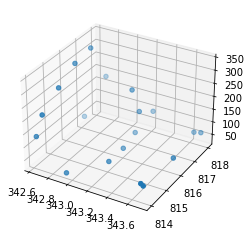

In [2]:
# ectract some features with random ids
features = [200]

feature_data = []
charges = []

for feature_id in features:
    feature = FeatureLoaderDDA(data_handle,feature_id)
    # estimate feature hull boundaries with averagine model for isotopic pattern and gaussian model for IMS
    data_tmp = feature.load_hull_data_3d(ims_model="gaussian",plot_feature=True)
    feature_data.append(data_tmp)
    charges.append(feature.charge)
    



In [3]:
# first feature data is needed to declare the model
 
s = feature_data[0]["Scan"].values
m = feature_data[0]["Mz"].values
# intensities must be floats, otherise observed data is not stored
# in inference data due to pymc bug 
# https://github.com/pymc-devs/pymc/issues/5586
i = feature_data[0]["Intensity"].values.astype("float")
z = charges[0]

myModel = ModelGLM3D(s.size,6,z,i,s,m,"",None)

In [4]:
traces = []
for z,feature in zip(charges,feature_data):
  scans = feature["Scan"].values
  mzs = feature["Mz"].values
  intensities = feature["Intensity"].values
  with myModel as model:
    # set data with current feature data
    pm.set_data({"charge":z,
                 "scan":scans,
                 "intensity":intensities.astype("float"),
                 "mz":np.tile(mzs,(6,1)).T,
                 "peaks":np.tile(np.arange(6),(scans.size,1)) # awful but mzs currently needed as column
    })
    # evalaution is driver method for pm.sample and plotting,
    # if resample not true, model would not sample if it was 
    # already fitted
    #
    model.evaluation()
    traces.append(model.idata.copy())


WARNING (aesara.tensor.basic_opt): Optimization Warning: The Op gamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I_t, I_s, MS_mz, MS_s, alpha, me]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
myModel._sample_predictive(False)

In [6]:
myModel._sample_predictive(False,True,var_names=["mu","obs"])

In [7]:
myModel._sample_predictive(True,False)

In [8]:
myModel._sample_predictive(True,True)

              Arviz will warn about non-defined InferenceData group 'prior_predictions'.
/home/tim/miniconda3/envs/proteolizard/lib/python3.8/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group prior_predictions is not defined in the InferenceData scheme
  warnings.warn(


In [9]:
myModel.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> posterior_predictive
	> predictions
	> predictions_constant_data
	> prior
	> prior_predictive
	> prior_predictions

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
df_obs = myModel.idata.predictions.obs.to_dataframe().reset_index()
df_mz = myModel.idata.predictions_constant_data.mz.to_dataframe().xs(0,level="mz_dim_1").reset_index()
df_scan = myModel.idata.predictions_constant_data.scan.to_dataframe().reset_index()
data_pred = pd.merge(df_mz,df_scan,left_on="mz_dim_0",right_on="scan_dim_0")
data = pd.merge(df_obs,data_pred,left_on="obs_dim_0",right_on="scan_dim_0").drop(columns=["scan_dim_0","mz_dim_0"])
data[["draw","chain","obs"]].groupby(["draw","chain"]).quantile([0.05,0.95])




In [ ]:
import plotly.express as px
z1 = myModel.idata.predictions["mu"].values.mean(axis=1)[0,:]
z2 = myModel.idata.predictions["mu"].values.mean(axis=1)[1,:]
z3 = myModel.idata.predictions["mu"].values.mean(axis=1)[2,:]
z4 = myModel.idata.predictions["mu"].values.mean(axis=1)[3,:]
chains = [z1,z2,z3,z4]
y = myModel.idata.predictions_constant_data["scan"].values
x = myModel.idata.predictions_constant_data["mz"].values[:,0]


In [ ]:
X = np.tile(x,4)
Y = np.tile(y,4)
chain_id = np.repeat([1,2,3,4],x.size).astype("str")
Z = np.stack(chains).flatten()

fig = px.scatter_3d(x=X, y=Y, z=Z,color=chain_id,opacity=0.1)

fig.show(renderer="notebook")

In [ ]:

z1 = myModel.idata.predictions["obs"].values.mean(axis=1)[0,:]
z2 = myModel.idata.predictions["obs"].values.mean(axis=1)[1,:]
z3 = myModel.idata.predictions["obs"].values.mean(axis=1)[2,:]
z4 = myModel.idata.predictions["obs"].values.mean(axis=1)[3,:]
chains = [z1,z2,z3,z4]
y = myModel.idata.predictions_constant_data["scan"].values
x = myModel.idata.predictions_constant_data["mz"].values[:,0]


In [ ]:
X = np.tile(x,4)
Y = np.tile(y,4)
chain_id = np.repeat([1,2,3,4],x.size).astype("str")
Z = np.stack(chains).flatten()

fig = px.scatter_3d(x=X, y=Y, z=Z,color=chain_id,opacity=0.1)

fig.show(renderer="notebook")

In [ ]:
az.plot_posterior(myModel.idata,var_names=["me"])

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Conclusion and Outlook</H4>
<br>
</div>


---



---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>References</H4>
<br>
</div>


---

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>To Do</H4>
<br>
</div>


---

Next Steps:

1. Parallelized GLM model
2. Model Evaluation for GLM in pystoms
3. Feature Manager -> handling many features at once
4. Test Model on GPU

5. CPU and GPU breakdown for bigger models in pymc4







---